# Load Data

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

In [2]:
!pip install kaggle

In [4]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
# Use the file upload widget
from google.colab import files
files.upload()  # Upload your kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beyzabal0","key":"91cff5f1980f29e22e2d53dcc5a1d50b"}'}

In [5]:
!chmod 600 /root/.kaggle/kaggle.json
!cp kaggle.json /root/.kaggle/

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
!kaggle competitions download -c home-credit-credit-risk-model-stability

 99% 3.12G/3.14G [00:27<00:00, 271MB/s]
100% 3.14G/3.14G [00:27<00:00, 121MB/s]


In [7]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [8]:
!unzip home-credit-credit-risk-model-stability.zip

Archive:  home-credit-credit-risk-model-stability.zip
  inflating: csv_files/test/test_applprev_1_0.csv  
  inflating: csv_files/test/test_applprev_1_1.csv  
  inflating: csv_files/test/test_applprev_1_2.csv  
  inflating: csv_files/test/test_applprev_2.csv  
  inflating: csv_files/test/test_base.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_0.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_1.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_2.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_3.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_4.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_0.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_1.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_10.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_11.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_2.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_3.csv  
  inflating: csv_files/test/test_credit_burea

In [9]:
dataPath = "/content/"

In [10]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [11]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

# Join Tables & Feature Engineering

In [12]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [13]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [14]:
data = data.to_pandas()
data['date_decision'] = pd.to_datetime(data['date_decision'])
print(f"Date range: {data['date_decision'].min()} to {data['date_decision'].max()}")
print(f"Week range: {data['WEEK_NUM'].min()} to {data['WEEK_NUM'].max()}")

Date range: 2019-01-01 00:00:00 to 2020-10-05 00:00:00
Week range: 0 to 91


In [15]:
# Pre-COVID training, COVID validation/testing
covid_start = pd.Timestamp('2020-03-01')
mid_covid = pd.Timestamp('2020-07-01')

# Split data based on these dates
train_data = data[data['date_decision'] < covid_start]
test_data = data[data['date_decision'] >= covid_start]

# Print split information
print(f"Training (pre-COVID): {len(train_data)} samples ({train_data['date_decision'].min()} to {train_data['date_decision'].max()})")
print(f"Test (later COVID): {len(test_data)} samples ({test_data['date_decision'].min()} to {test_data['date_decision'].max()})")

Training (pre-COVID): 1232695 samples (2019-01-01 00:00:00 to 2020-02-29 00:00:00)
Test (later COVID): 293964 samples (2020-03-01 00:00:00 to 2020-10-05 00:00:00)


In [16]:
cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)
print(cols_pred)

base_train = train_data[["case_id","date_decision", "WEEK_NUM","MONTH", "target"]]
y_train = train_data["target"]
X_train = train_data[cols_pred]

base_test = test_data[["case_id","date_decision", "WEEK_NUM","MONTH", "target"]]
y_test = test_data["target"]
X_test = test_data[cols_pred]

for df in [X_train, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

<ipython-input-7-601ef9b9fd56>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("string").astype('category')
<ipython-input-7-601ef9b9fd56>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(new_dtype)
<ipython-input-7-601ef9b9fd56>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [17]:
print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

Train: (1232695, 48)
Test: (293964, 48)


In [18]:
print(f"Train: {y_train.shape}")
print(f"Test: {y_test.shape}")

Train: (1232695,)
Test: (293964,)


# Reduce Memory Usage

In [19]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    return df

In [20]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

<ipython-input-19-b5f18661dcfe>:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-19-b5f18661dcfe>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float32)
<ipython-input-19-b5f18661dcfe>:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-19-b5f18661dcfe>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

# Light GBM

In [21]:
import gc
gc.collect()

0

In [22]:
del data, train_data, test_data
gc.collect()

0

In [23]:
lgb_train = lgb.Dataset(X_train, label=y_train)

params = {
    # Core parameters
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",

    # Tree structure parameters
    "max_depth": 6,
    "num_leaves": 63,
    "min_data_in_leaf": 20,

    # Learning parameters
    "learning_rate": 0.01,
    "n_estimators": 3000,

    # Regularization
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "min_gain_to_split": 0.1,

    # Sampling parameters
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 3,

    # Additional parameters
    "verbose": -1,
}


cv_results = lgb.cv(
    params,
    lgb_train,
    nfold=3,
    stratified= True,
    num_boost_round=5000,
    callbacks=[
        lgb.log_evaluation(100),
        lgb.early_stopping(50)
    ]
)

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:738: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Training until validation scores don't improve for 50 rounds
[100]	cv_agg's valid auc: 0.709758 + 0.00163186
[200]	cv_agg's valid auc: 0.722161 + 0.00136584
[300]	cv_agg's valid auc: 0.72906 + 0.00121661
[400]	cv_agg's valid auc: 0.733625 + 0.00151
[500]	cv_agg's valid auc: 0.736887 + 0.00147184
[600]	cv_agg's valid auc: 0.739413 + 0.00167161
[700]	cv_agg's valid auc: 0.741333 + 0.00167266
[800]	cv_agg's valid auc: 0.742862 + 0.00180253
[900]	cv_agg's valid auc: 0.744126 + 0.00184266
[1000]	cv_agg's valid auc: 0.745295 + 0.00178185
[1100]	cv_agg's valid auc: 0.746232 + 0.0018034
[1200]	cv_agg's valid auc: 0.747087 + 0.00174644
[1300]	cv_agg's valid auc: 0.747755 + 0.0017849
[1400]	cv_agg's valid auc: 0.748399 + 0.00177948
[1500]	cv_agg's valid auc: 0.748997 + 0.00172733
[1600]	cv_agg's valid auc: 0.749508 + 0.00174245
[1700]	cv_agg's valid auc: 0.749966 + 0.001688
[1800]	cv_agg's valid auc: 0.750419 + 0.00168414


KeyboardInterrupt: 

In [ ]:
best_iteration = len(cv_results['valid auc-mean'])
print(f"Best number of iterations: {best_iteration}")

In [25]:
gc.collect()

25

In [26]:
gbm = lgb.train(
    params=params,
    train_set=lgb_train,
    num_boost_round=2999  # Use the optimal number from CV
)

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [27]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return gini_in_time, avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [28]:
for base, X in [(base_train, X_train)]:
    y_pred = gbm.predict(X)
    train_prevalence = y_train.mean()
    threshold = np.percentile(y_pred, 100 * (1 - train_prevalence))
    y_pred_labels = (y_pred > threshold).astype(int)
    base["score"] = y_pred
    base["pred"] = y_pred_labels
print(f'The AUC score on the train set for Light GBM is: {roc_auc_score(base_train["target"], base_train["score"])}')
gini_in_time_train, stability_score_train = gini_stability(base_train)
print(f'The stability score on the train set is: {stability_score_train}')

The AUC score on the train set for Light GBM is: 0.8145694807459083
The stability score on the train set is: 0.6061505090293136


In [29]:
gc.collect()

0

In [30]:
from sklearn.base import clone

#Retraining

In [31]:
#Retraining
start_week = base_test["WEEK_NUM"].min()  # First week to monitor (after training)
end_week = base_test["WEEK_NUM"].max()    # Last week in dataset
window_size = 4  # Number of weeks per window
stability_threshold = -1  # Warning threshold

# Initialize storage for predictions
all_predictions = {}
test = pd.concat([base_test, X_test], axis=1, ignore_index = False)
current_model = gbm
last_retrain_week = start_week - 1

# Make predictions for each week
for week in range(start_week, end_week + 1):
    gc.collect()
    # Get data for current week
    week_data = test[test['WEEK_NUM'] == week]

    if len(week_data) == 0:
        print(f"No data for week {week}, skipping.")
        continue

    X_week = week_data.drop(['WEEK_NUM','date_decision', 'target', 'MONTH', 'case_id'], axis=1)
    scores = current_model.predict(X_week)

        # Store predictions
    all_predictions[week] = {'week': week,'date_decision': week_data['date_decision'].values,
                             'actual': week_data['target'].values, 'predicted': scores}

    # Check if we have enough weeks for a window
    if week >= start_week + window_size - 1:
        # Prepare data for stability calculation
        window_start = week - window_size + 1
        window_data = pd.DataFrame()

        # Combine predictions for the window
        for w in range(window_start, week + 1):
            if w in all_predictions:
                temp_df = pd.DataFrame({
                    'WEEK_NUM': [w] * len(all_predictions[w]['actual']),
                    'date_decision': all_predictions[w]['date_decision'],
                    'target': all_predictions[w]['actual'],
                    'score': all_predictions[w]['predicted']
                })
                window_data = pd.concat([window_data, temp_df])

        # Calculate stability
        gini_values, stability = gini_stability(window_data)

        # Check if stability is below threshold
        if stability < stability_threshold:
            print(f"WARNING: Week {window_start}-{week} stability = {stability:.4f} - below threshold!")
            print(f"Consider retraining model with data up to week {week}")

            # Get training data up to current week
            retrain_data = pd.concat([X_train, y_train], axis=1)  # Original training data
            new_train_data = test[test['WEEK_NUM'] <= week]  # New data up to current week
            combined_train = pd.concat([retrain_data, new_train_data])

            # Retrain model
            X_retrain = combined_train.drop(['WEEK_NUM', 'date_decision','target', 'MONTH', 'case_id'], axis=1)
            y_retrain = combined_train['target']
            object_columns = X_retrain.select_dtypes(include=['object']).columns
            X_retrain[object_columns] = X_retrain[object_columns].astype('category')
            lgb_retrain = lgb.Dataset(X_retrain, label=y_retrain)

            # Clone the original model to keep the same parameters
            current_model = lgb.train(params=params, train_set=lgb_retrain,
                                        num_boost_round=3000 )
            # Update last retraining week
            last_retrain_week = week
            print(f"Model retrained using data up to week {week}")

        else:
            print(f"Week {window_start}-{week} stability = {stability:.4f}")

Week 60-63 stability = 0.4798
Week 61-64 stability = 0.4879
Week 62-65 stability = 0.1390
Consider retraining model with data up to week 66


<ipython-input-31-9b8de6c6428b>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_train = pd.concat([retrain_data, new_train_data])
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Model retrained using data up to week 66
Week 64-67 stability = 0.4969
Week 65-68 stability = -0.2742
Consider retraining model with data up to week 69


<ipython-input-31-9b8de6c6428b>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_train = pd.concat([retrain_data, new_train_data])
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Model retrained using data up to week 69
Week 67-70 stability = -0.3967
Week 68-71 stability = 0.4845
Week 69-72 stability = 0.5030
Week 70-73 stability = -0.8188
Week 71-74 stability = -0.0558
Week 72-75 stability = 0.5412
Week 73-76 stability = 0.5553
Week 74-77 stability = -0.3695
Week 75-78 stability = 0.5137
Week 76-79 stability = 0.5462
Week 77-80 stability = 0.5367
Consider retraining model with data up to week 81


<ipython-input-31-9b8de6c6428b>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_train = pd.concat([retrain_data, new_train_data])
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Model retrained using data up to week 81
Consider retraining model with data up to week 82


<ipython-input-31-9b8de6c6428b>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_train = pd.concat([retrain_data, new_train_data])
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Model retrained using data up to week 82
Week 80-83 stability = 0.5060
Week 81-84 stability = 0.5061
Week 82-85 stability = 0.5255
Week 83-86 stability = 0.5502
Week 84-87 stability = 0.5428
Week 85-88 stability = 0.3646
Week 86-89 stability = 0.5618
Week 87-90 stability = -0.0247
Week 88-91 stability = 0.4002


In [32]:
# Create an empty DataFrame to store all predictions
test_preds = pd.DataFrame(columns=['WEEK_NUM','date_decision','target', 'score'])

# Loop through the all_predictions dictionary
for week, data in all_predictions.items():
    # Create a temporary DataFrame for this week
    week_df = pd.DataFrame({
        'WEEK_NUM': week,
        'date_decision': data['date_decision'],
        'target': data['actual'],
        'score': data['predicted']
    })

    # Append to the main DataFrame
    test_preds = pd.concat([test_preds, week_df], ignore_index=False)
test_preds['target'] = test_preds['target'].astype(int)
# Show the first few rows
print(test_preds.head())
print(f"Total observations: {len(test_preds)}")

  WEEK_NUM date_decision  target     score
0       60    2020-03-02       0  0.012029
1       60    2020-03-02       0  0.068635
2       60    2020-03-02       0  0.090495
3       60    2020-03-02       0  0.055733
4       60    2020-03-02       1  0.078270
Total observations: 293964


<ipython-input-32-f03e136d7832>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_preds = pd.concat([test_preds, week_df], ignore_index=False)


# Evaluation

In [33]:
# Calculate training prevalence (assuming you still have y_train available)
train_prevalence = y_train.mean()

# Apply the threshold to get class labels
threshold = np.percentile(test_preds['score'], 100 * (1 - train_prevalence))
test_preds['pred'] = (test_preds['score'] > threshold).astype(int)

In [34]:
print(f'The AUC score on the train set for Light GBM is: {roc_auc_score(base_train["target"], base_train["score"])}')
print(f'The AUC score on the test set for Light GBM is: {roc_auc_score(test_preds["target"], test_preds["score"])}')

The AUC score on the train set for Light GBM is: 0.8145694807459083
The AUC score on the test set for Light GBM is: 0.7755899337246442


In [35]:
print(f'The classification error on the train set for LightGBM is: {1- accuracy_score(base_train["target"], base_train["pred"])}')
print(f'The classification error on the test set for LightGBM is: {1-accuracy_score(test_preds["target"], test_preds["pred"])}')

The classification error on the train set for LightGBM is: 0.04814491824822853
The classification error on the test set for LightGBM is: 0.04845151106938261


In [36]:
print(f'The brier score on the train set for LightGBM is: {brier_score_loss(base_train["target"], base_train["score"])}')
print(f'The brier score on the test set for LightGBM is: {brier_score_loss(test_preds["target"], test_preds["score"])}')

The brier score on the train set for LightGBM is: 0.028890033075117786
The brier score on the test set for LightGBM is: 0.024928890780832064


In [37]:
gini_in_time_train, stability_score_train = gini_stability(base_train)
gini_in_time_test, stability_score_test = gini_stability(test_preds)

print(f'The stability score on the train set is: {stability_score_train}')
print(f'The stability score on the test set is: {stability_score_test}')

The stability score on the train set is: 0.6061505090293136
The stability score on the test set is: 0.5099689446050639


In [38]:
test_preds

,WEEK_NUM,date_decision,target,score,pred
0,60,2020-03-02,0,0.012029,0
1,60,2020-03-02,0,0.068635,0
2,60,2020-03-02,0,0.090495,0
3,60,2020-03-02,0,0.055733,0
4,60,2020-03-02,1,0.078270,0
...,...,...,...,...,...
12669,91,2020-10-05,0,0.004215,0
12670,91,2020-10-05,0,0.005150,0
12671,91,2020-10-05,0,0.039385,0
12672,91,2020-10-05,0,0.003717,0


In [39]:
# Combine all three datasets into one
full_combined_df = pd.concat(
    [base_train,test_preds],
    axis=0,          # Concatenate vertically (stack rows)
    ignore_index=True  # Keep original indices
)

In [40]:
gini_in_time, stability_score = gini_stability(full_combined_df)

print(f'The stability score is: {stability_score}')

The stability score is: 0.5001664667587351


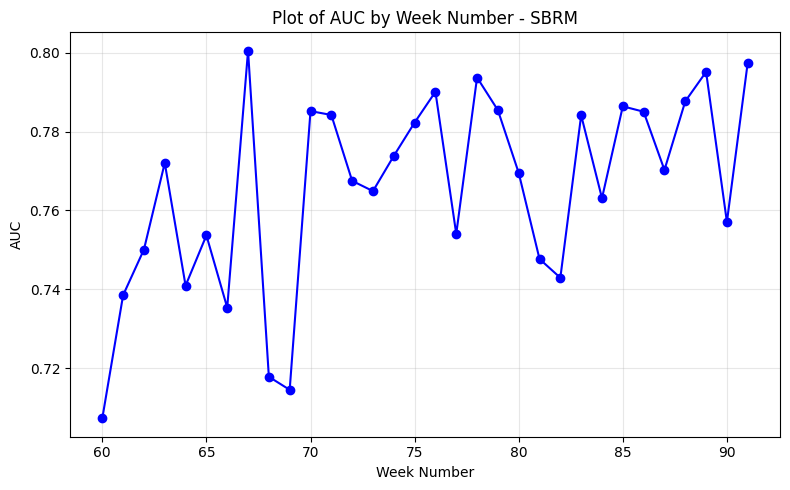

In [41]:
import matplotlib.pyplot as plt
import numpy as np


# Convert Gini to AUC: AUC = (Gini + 1) / 2
# Using list comprehension to apply the operation to each element
auc_values = [(g + 1) / 2 for g in gini_in_time_test]

# Create x-axis values (indices)
x = test_preds["WEEK_NUM"].unique()

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x, auc_values, 'o-', color='blue')

# Add labels and title
plt.xlabel('Week Number')
plt.ylabel('AUC')
plt.title('Plot of AUC by Week Number - SBRM')

# Add grid
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

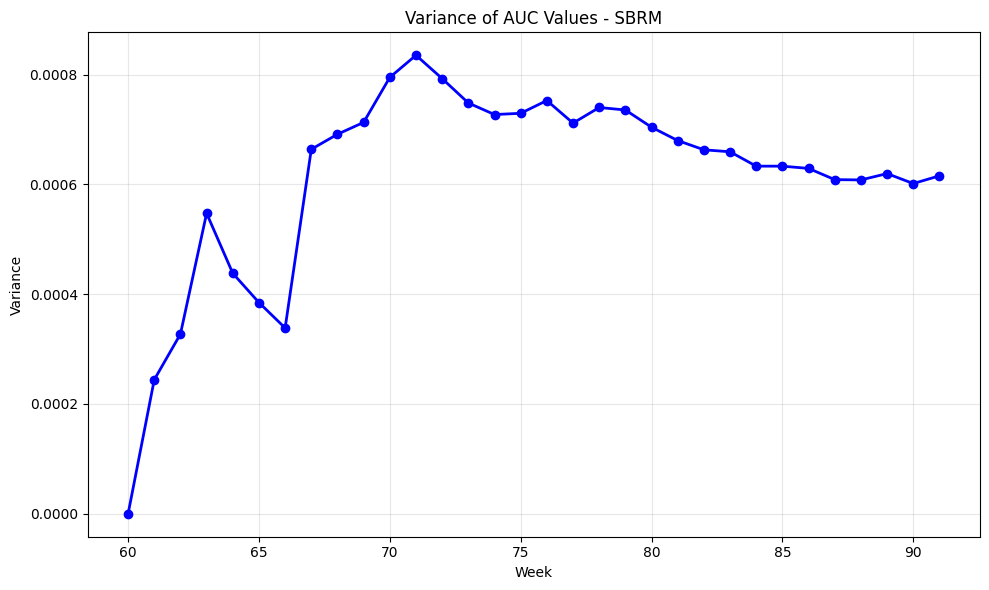

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate rolling variance (variance at each point using all previous points)
rolling_variance = []
for i in range(1, len(auc_values) + 1):
    subset = auc_values[:i]
    variance = np.var(subset)
    rolling_variance.append(variance)

# Plot the variance
plt.figure(figsize=(10, 6))
plt.plot(test_preds["WEEK_NUM"].unique(), rolling_variance, 'o-', color='blue', linewidth=2)
plt.xlabel('Week')
plt.ylabel('Variance')
plt.title('Variance of AUC Values - SBRM')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [43]:
def calculate_weekly_rolling_stability(df, window_weeks, w_fallingrate=88.0, w_resstd=-0.5):
    """
    Calculate rolling stability metrics on a weekly basis.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing WEEK_NUM, target, and score columns
    window_weeks : int, default=4
        Number of weeks to include in each rolling window
    w_fallingrate : float, default=88.0
        Weight for the falling rate
    w_resstd : float, default=-0.5
        Weight for the residual standard deviation

    Returns:
    --------
    pd.DataFrame
        DataFrame with weekly stability metrics
    """
    # Get unique weeks
    unique_weeks = sorted(df['WEEK_NUM'].unique())

    # For each week starting from window_weeks, calculate stability using previous window_weeks
    results = []

    for i in range(window_weeks-1, len(unique_weeks)):
        # Get the current ending week
        end_week = unique_weeks[i]

        # Get the weeks in this window
        window_week_nums = unique_weeks[i-(window_weeks-1):i+1]

        # Filter data for these weeks
        window_data = df[df['WEEK_NUM'].isin(window_week_nums)].copy()

        # Calculate stability for this window
        gini_values, stability_score = gini_stability(window_data, w_fallingrate, w_resstd)

        results.append({
            'end_week': end_week,
            'window_weeks': window_week_nums,
            'stability_score': stability_score,
            'gini_values': gini_values,
            'avg_gini': np.mean(gini_values),
            'week_count': len(gini_values)
        })

    return pd.DataFrame(results)

def plot_weekly_stability(stability_df):
    """
    Plot the weekly stability metrics.

    Parameters:
    -----------
    stability_df : pd.DataFrame
        DataFrame with weekly stability metrics, as returned by calculate_weekly_rolling_stability
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

    # Plot stability score
    ax1.plot(stability_df['end_week'], stability_df['stability_score'], 'b-', marker='o')
    ax1.set_title('Weekly Stability Score - SBRM')
    ax1.set_xlabel('Week')
    ax1.set_ylabel('Stability Score')
    mean_stability = stability_df['stability_score'].mean()
    ax1.axhline(y=mean_stability, color='r', linestyle='--', label=f'Mean: {mean_stability:.2f}')
    ax1.grid(True)

    # Plot average GINI
    ax2.plot(stability_df['end_week'], stability_df['avg_gini'], 'g-', marker='o')
    ax2.set_title('Average GINI in Rolling Window - SBRM')
    ax2.set_xlabel('End Week')
    ax2.set_ylabel('Average GINI')
    ax2.grid(True)

    plt.tight_layout()
    return

In [44]:
# Calculate weekly stability with a 4-week window
stability_results = calculate_weekly_rolling_stability(test_preds, window_weeks=4)

# Display results
print(stability_results[['end_week', 'stability_score', 'avg_gini']])

    end_week  stability_score  avg_gini
0         63         0.479835  0.483920
1         64         0.487929  0.500756
2         65         0.138997  0.508345
3         66        -1.222359  0.500973
4         67         0.496876  0.515210
5         68        -0.274188  0.503648
6         69        -2.104060  0.484050
7         70        -0.396695  0.508986
8         71         0.484529  0.500834
9         72         0.502955  0.525695
10        73        -0.818797  0.550907
11        74        -0.055829  0.545220
12        75         0.541177  0.544252
13        76         0.555275  0.555554
14        77        -0.369455  0.550123
15        78         0.513672  0.560071
16        79         0.546164  0.561644
17        80         0.536738  0.551352
18        81        -2.166862  0.548171
19        82        -2.111127  0.522759
20        83         0.506014  0.522116
21        84         0.506127  0.518901
22        85         0.525534  0.538273
23        86         0.550189  0.559344


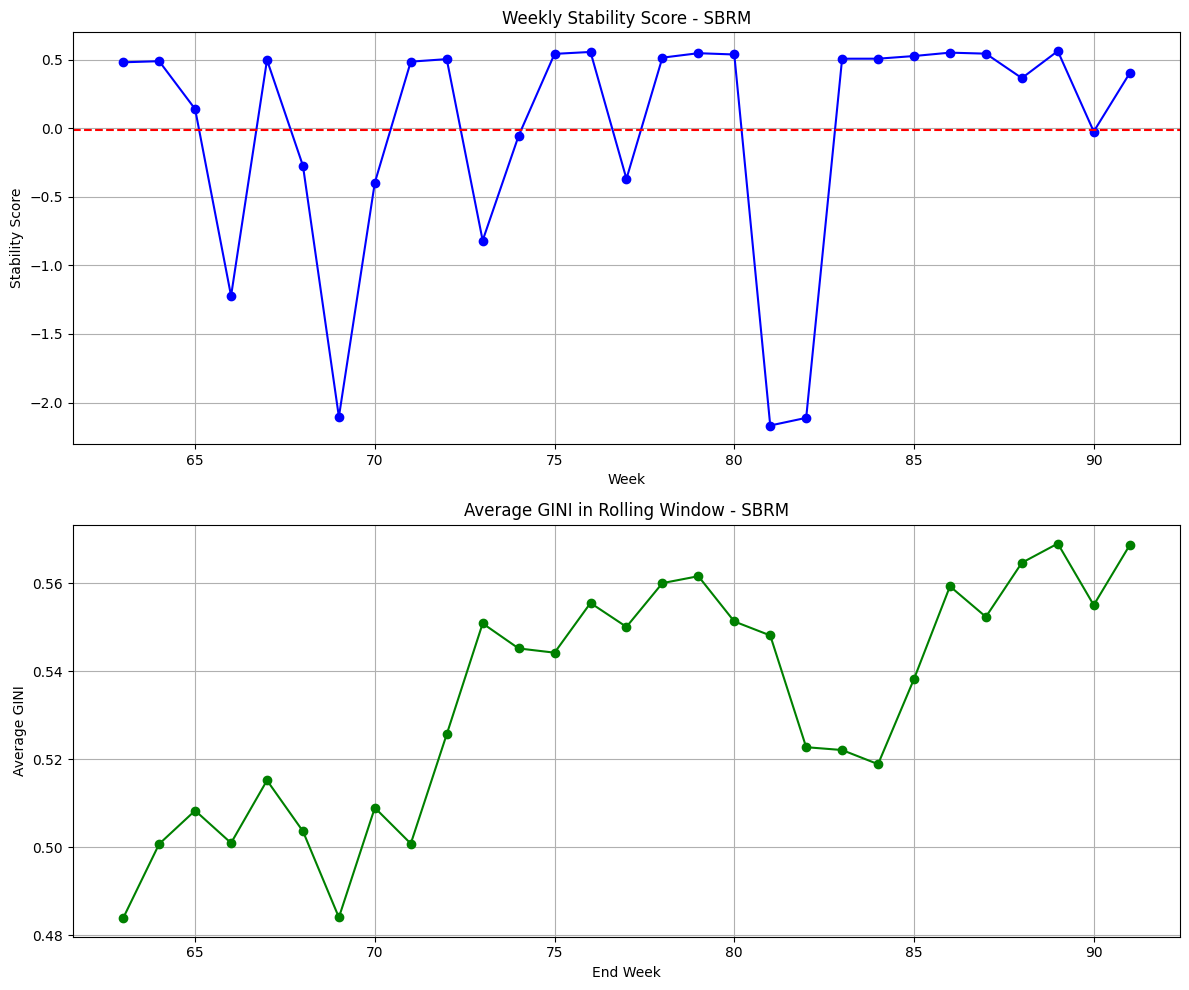

In [45]:
plot_weekly_stability(stability_results)

In [46]:
def plot_weekly_stability_auc(stability_df):
    """
    Plot the weekly stability metrics (stability score and GINI) on the same graph.

    Parameters:
    -----------
    stability_df : pd.DataFrame
        DataFrame with weekly stability metrics, as returned by calculate_weekly_rolling_stability
    """
    # Clear any existing plots to prevent duplicates
    plt.clf()
    plt.close('all')

    # Create a new figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create twin y-axis for GINI
    ax2 = ax.twinx()

    # Plot stability score on primary axis
    line1, = ax.plot(stability_df['end_week'], stability_df['stability_score'], 'b-', marker='o', label='Stability Score')
    ax.set_ylabel('Stability Score', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Plot average GINI on secondary axis
    line2, = ax2.plot(stability_df['end_week'], (stability_df['avg_gini']+1)/2, 'g-', marker='o', label='AUC')
    ax2.set_ylabel('AUC', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Add mean stability line
    mean_stability = stability_df['stability_score'].mean()
    line3 = ax.axhline(y=mean_stability, color='r', linestyle='--', label=f'Mean Stability: {mean_stability:.2f}')

    # Add mean GINI line
    mean_auc = ((stability_df['avg_gini']+1)/2).mean()
    line4 = ax2.axhline(y=mean_auc, color='orange', linestyle='--', label=f'Mean AUC: {mean_auc:.2f}')

    # Set title and labels
    ax.set_title('Weekly Stability Score and AUC - SBRM')
    ax.set_xlabel('Week')
    ax.grid(True)

    # Combine legends from both axes and place it outside the plot area
    lines = [line1, line2, line3, line4]
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.0, -0.15), ncol=4)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for the legend at the bottom

    return

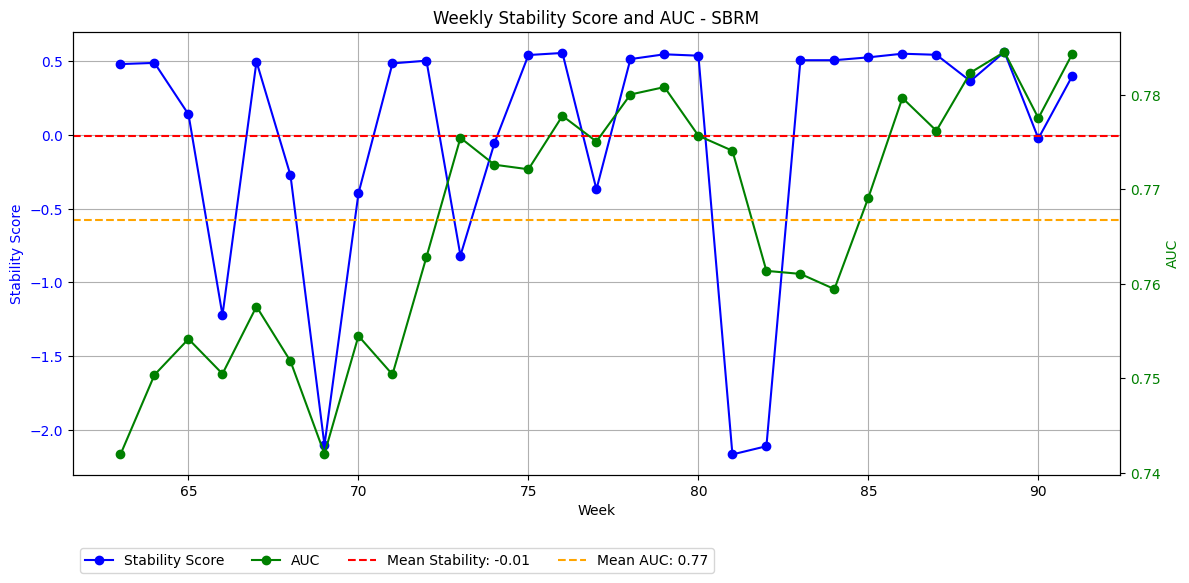

In [47]:
plot_weekly_stability_auc(stability_results)

In [48]:
print("AUC:", roc_auc_score(full_combined_df["target"], full_combined_df["score"]))
print("Stability:", stability_score)

AUC: 0.8079289706670723
Stability: 0.5001664667587351


In [49]:
gini_60_65, stability_60_65 = gini_stability(full_combined_df[(full_combined_df['date_decision'] >= covid_start) & (full_combined_df['WEEK_NUM'] <= 65)])
print("AUC week 60-65:", np.mean([(g + 1) / 2 for g in gini_60_65]))
print("Stability week 60-65:", stability_60_65)

AUC week 60-65: 0.7437350223656782
Stability week 60-65: 0.47256817986752453


In [50]:
gini_65_70, stability_65_70 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] > 65) & (full_combined_df['WEEK_NUM'] <= 70)])
print("AUC week 65-70:", np.mean([(g + 1) / 2 for g in gini_65_70]))
print("Stability week 65-70:", stability_65_70)

AUC week 65-70: 0.7506597028132184
Stability week 65-70: 0.4658614014613799


In [51]:
gini_70_78, stability_70_78 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] > 70) & (full_combined_df['date_decision'] < mid_covid)])
print("AUC week 70-78:", np.mean([(g + 1) / 2 for g in gini_70_78]))
print("Stability week 70-78:", stability_70_78)

AUC week 70-78: 0.7727100542644276
Stability week 70-78: 0.28515030766695965


In [57]:
gini_78_91, stability_78_91 = gini_stability(full_combined_df[(full_combined_df['date_decision'] >= mid_covid)])
print("AUC week 78-91:", np.mean([(g + 1) / 2 for g in gini_78_91]))
print("Stability week 78-91:", stability_78_91)

AUC week 78-91: 0.7765163001005418
Stability week 78-91: 0.5356568574365154


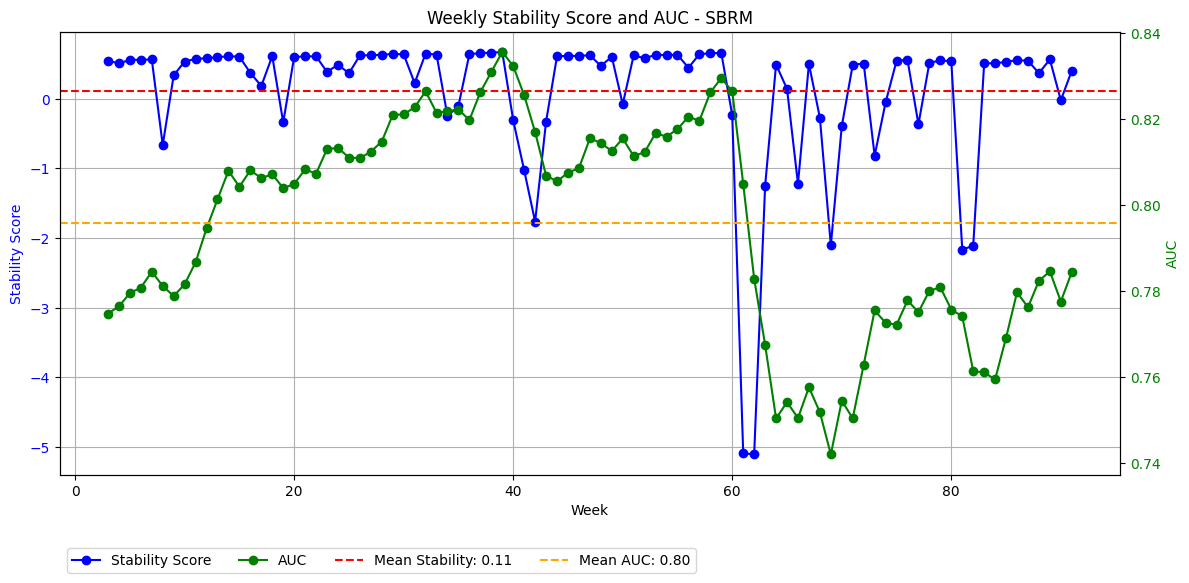

In [52]:
stability_results_all = calculate_weekly_rolling_stability(full_combined_df, window_weeks=4)
plot_weekly_stability_auc(stability_results_all)

In [53]:
def plot_stability_decomposition(model_name, gini_values, weeks=None):
    """
    Create a detailed visualization of model stability decomposition with proper display of all data points.
    Includes percentage contribution of each component in brackets.

    Parameters:
    -----------
    model_name : str
        Name of the model being analyzed
    gini_values : list or array
        Gini coefficient values for each week
    weeks : list or array, optional
        Week numbers (will use 0 to len(gini_values)-1 if None)
    """
    if weeks is None:
        weeks = np.arange(len(gini_values))

    # Ensure inputs are numpy arrays
    weeks = np.array(weeks)
    gini_values = np.array(gini_values)

    # Calculate trend line
    x = np.array(weeks)
    y = np.array(gini_values)
    a, b = np.polyfit(x, y, 1)
    y_trend = a * x + b
    residuals = y - y_trend

    # Calculate stability components
    avg_gini = np.mean(gini_values)
    w_fallingrate = 88.0
    w_resstd = -0.5
    trend_component = w_fallingrate * min(0, a)
    res_std = np.std(residuals)
    residual_component = w_resstd * res_std
    final_score = avg_gini + trend_component + residual_component

    # Calculate percentage contributions of each component
    # Use absolute values for percentage calculation to handle negative values correctly
    total_absolute_contribution = abs(avg_gini) + abs(trend_component) + abs(residual_component)

    if total_absolute_contribution > 0:
        avg_gini_pct = (abs(avg_gini) / total_absolute_contribution) * 100
        trend_component_pct = (abs(trend_component) / total_absolute_contribution) * 100
        residual_component_pct = (abs(residual_component) / total_absolute_contribution) * 100
    else:
        avg_gini_pct = trend_component_pct = residual_component_pct = 0

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12),
                                        gridspec_kw={'height_ratios': [3, 1, 2]})  # Increased bottom panel height

    # Plot 1: Gini values and trend
    # Use scatter for individual points and line for connecting them
    ax1.scatter(weeks, gini_values, color='blue', s=30, zorder=3)
    ax1.plot(weeks, gini_values, '-', color='blue', alpha=0.6, label='Weekly Gini')

    # Add trend line and average
    ax1.plot(weeks, y_trend, 'r--', linewidth=2, label=f'Trend (slope={a:.4f})')
    ax1.axhline(y=avg_gini, color='g', linestyle=':', linewidth=2, label=f'Avg Gini={avg_gini:.4f}')

    # Style the plot
    ax1.set_ylabel('Gini Coefficient', fontsize=12)
    ax1.set_title(f'Model: {model_name} - Stability Score: {final_score:.4f}', fontsize=14)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Set y-axis limits with some padding
    y_min = min(gini_values) - 0.03
    y_max = max(gini_values) + 0.03
    ax1.set_ylim(y_min, y_max)

    # Plot 2: Residuals - make sure each bar is visible
    bar_width = 0.7  # Adjust based on number of weeks
    ax2.bar(weeks, residuals, color='orange', alpha=0.7, width=bar_width)
    ax2.axhline(y=0, color='k', linestyle='-')
    ax2.set_ylabel('Residuals', fontsize=12)
    ax2.set_title(f'Residual StdDev: {res_std:.4f} (Impact: {residual_component:.4f})', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Set symmetric y limits for residuals
    res_limit = max(abs(min(residuals)), abs(max(residuals))) * 1.1
    ax2.set_ylim(-res_limit, res_limit)
    ax2.set_xlabel('Week', fontsize=12)

    # Plot 3: Component Breakdown - Horizontal bar chart with percentages
    components = [avg_gini, trend_component, residual_component]
    percentages = [avg_gini_pct, trend_component_pct, residual_component_pct]

    # Create component labels with percentages
    labels = [
        f'Avg Gini [{avg_gini_pct:.1f}%]',
        f'Trend Component [{trend_component_pct:.1f}%]',
        f'Residual Component [{residual_component_pct:.1f}%]'
    ]

    colors = ['green', 'blue' if trend_component > 0 else 'red', 'orange']

    y_pos = np.arange(len(components))

    # Create horizontal bar chart
    bars = ax3.barh(y_pos, components, color=colors, height=0.6)
    ax3.axvline(x=0, color='k', linestyle='-')
    ax3.set_ylabel('Component', fontsize=12)
    ax3.set_xlabel('Score Contribution', fontsize=12)
    ax3.set_title(f'Component Breakdown (Final Score: {final_score:.4f})', fontsize=12)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(labels, fontsize=11)
    ax3.grid(True, axis='x', alpha=0.3)

    # Add final score line
    ax3.axvline(x=final_score, color='blue', linestyle='--', linewidth=2)
    ax3.text(final_score, len(components), f'Final: {final_score:.4f}',
             color='blue', fontweight='bold', va='bottom', ha='center')

    # Add value labels on component bars
    for i, v in enumerate(components):
        # Position the text inside or outside the bar based on value
        if abs(v) > 0.05:
            ax3.text(v/2 if v > 0 else v/2, i, f'{v:.4f}',
                    ha='center', va='center', color='white', fontweight='bold', fontsize=10)
        else:
            # For very small values, position text at end of bar
            ax3.text(v + (0.01 if v > 0 else -0.01), i, f'{v:.4f}',
                    ha='left' if v > 0 else 'left', va='center',
                    color='black', fontweight='bold', fontsize=10)

    # Remove the connection between subplots (no shared x-axis)
    plt.subplots_adjust(hspace=0.3)

    # Add specific x-ticks for weeks with reasonable intervals
    week_step = max(1, len(weeks) // 10)  # Show about 10 ticks
    week_ticks = weeks[::week_step]
    ax1.set_xticks(week_ticks)
    ax1.set_xticklabels([str(int(w)) for w in week_ticks])

    ax2.set_xticks(week_ticks)
    ax2.set_xticklabels([str(int(w)) for w in week_ticks])

    # Set x-axis limits for component chart to ensure all bars are fully visible
    # Find the minimum negative component value (if any)
    min_component = min(min(components), 0)  # Minimum of components or 0, whichever is smaller
    max_component = max(max(components), final_score)  # Maximum of components or final score

    # Set x-axis limits with more space on the left side for negative components
    left_margin = abs(min_component) * 1.5  # Extra space for negative components
    right_margin = max_component * 1.5  # Extra space for positive components

    ax3.set_xlim(-left_margin, right_margin)

    plt.tight_layout()
    return fig

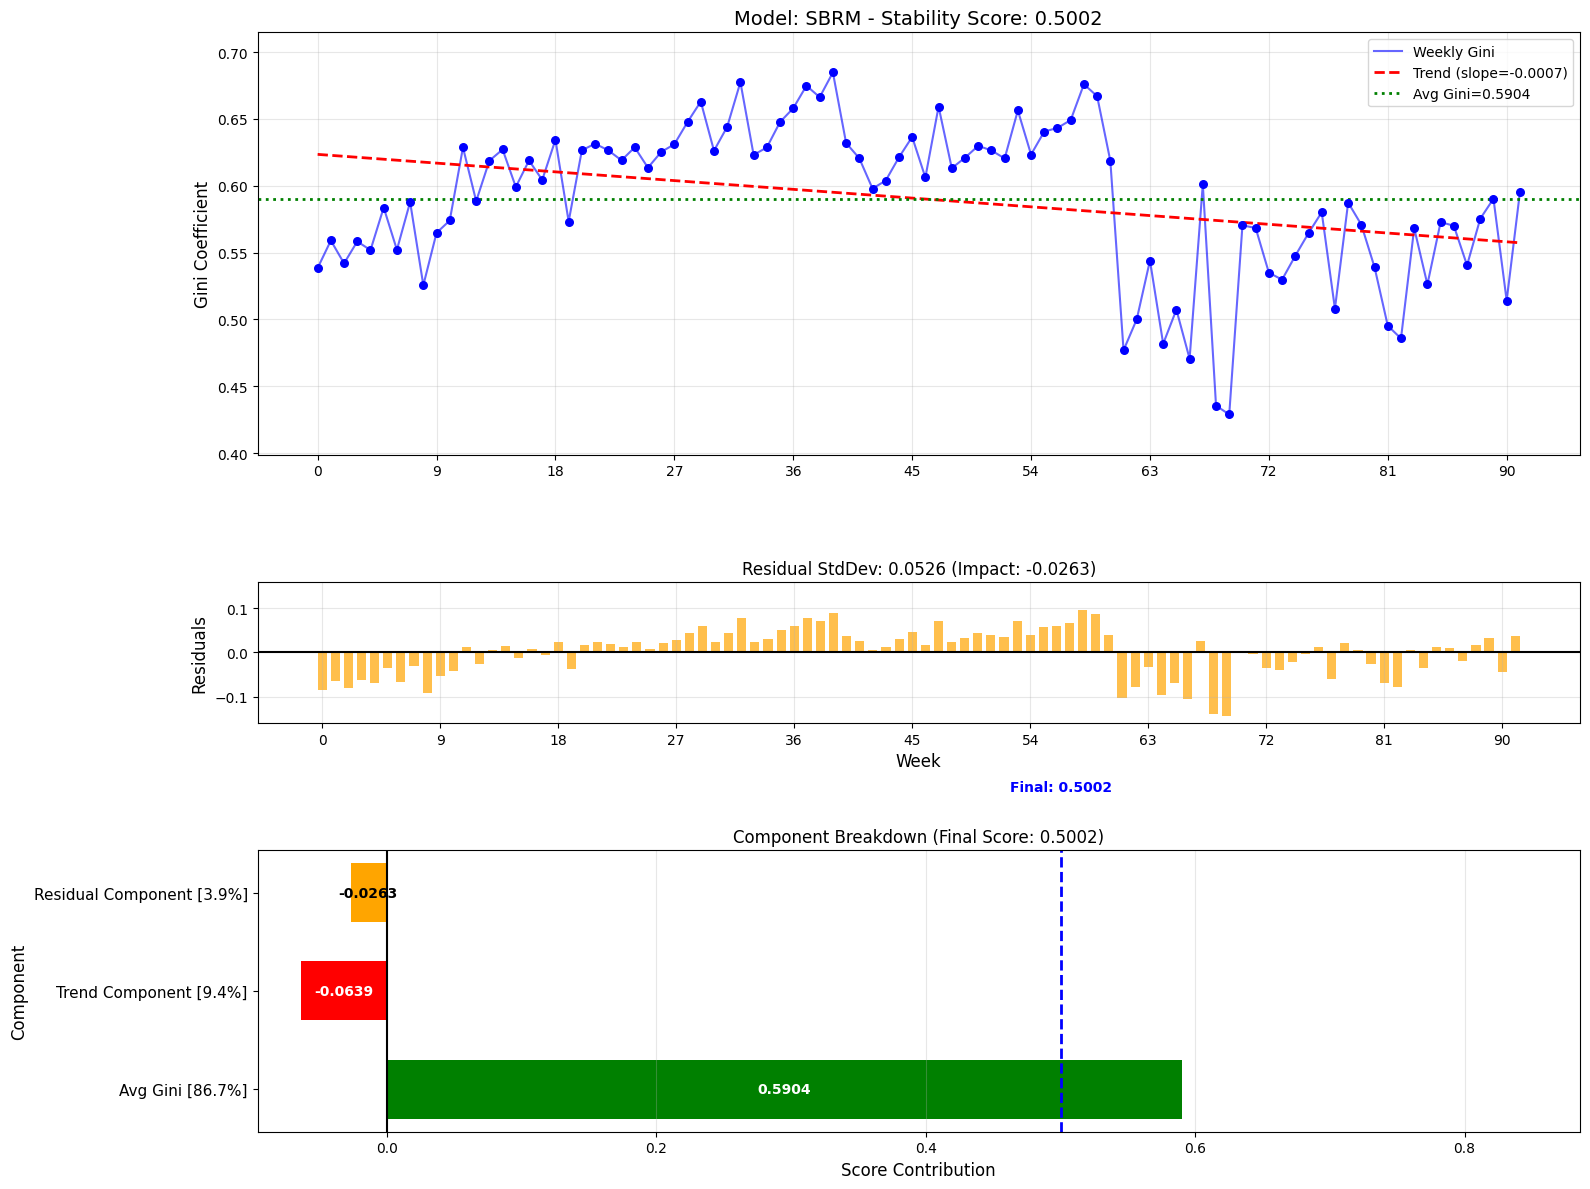

In [54]:
weeks = np.arange(92)
fig = plot_stability_decomposition("SBRM", gini_in_time, weeks)
plt.savefig('SBRM_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

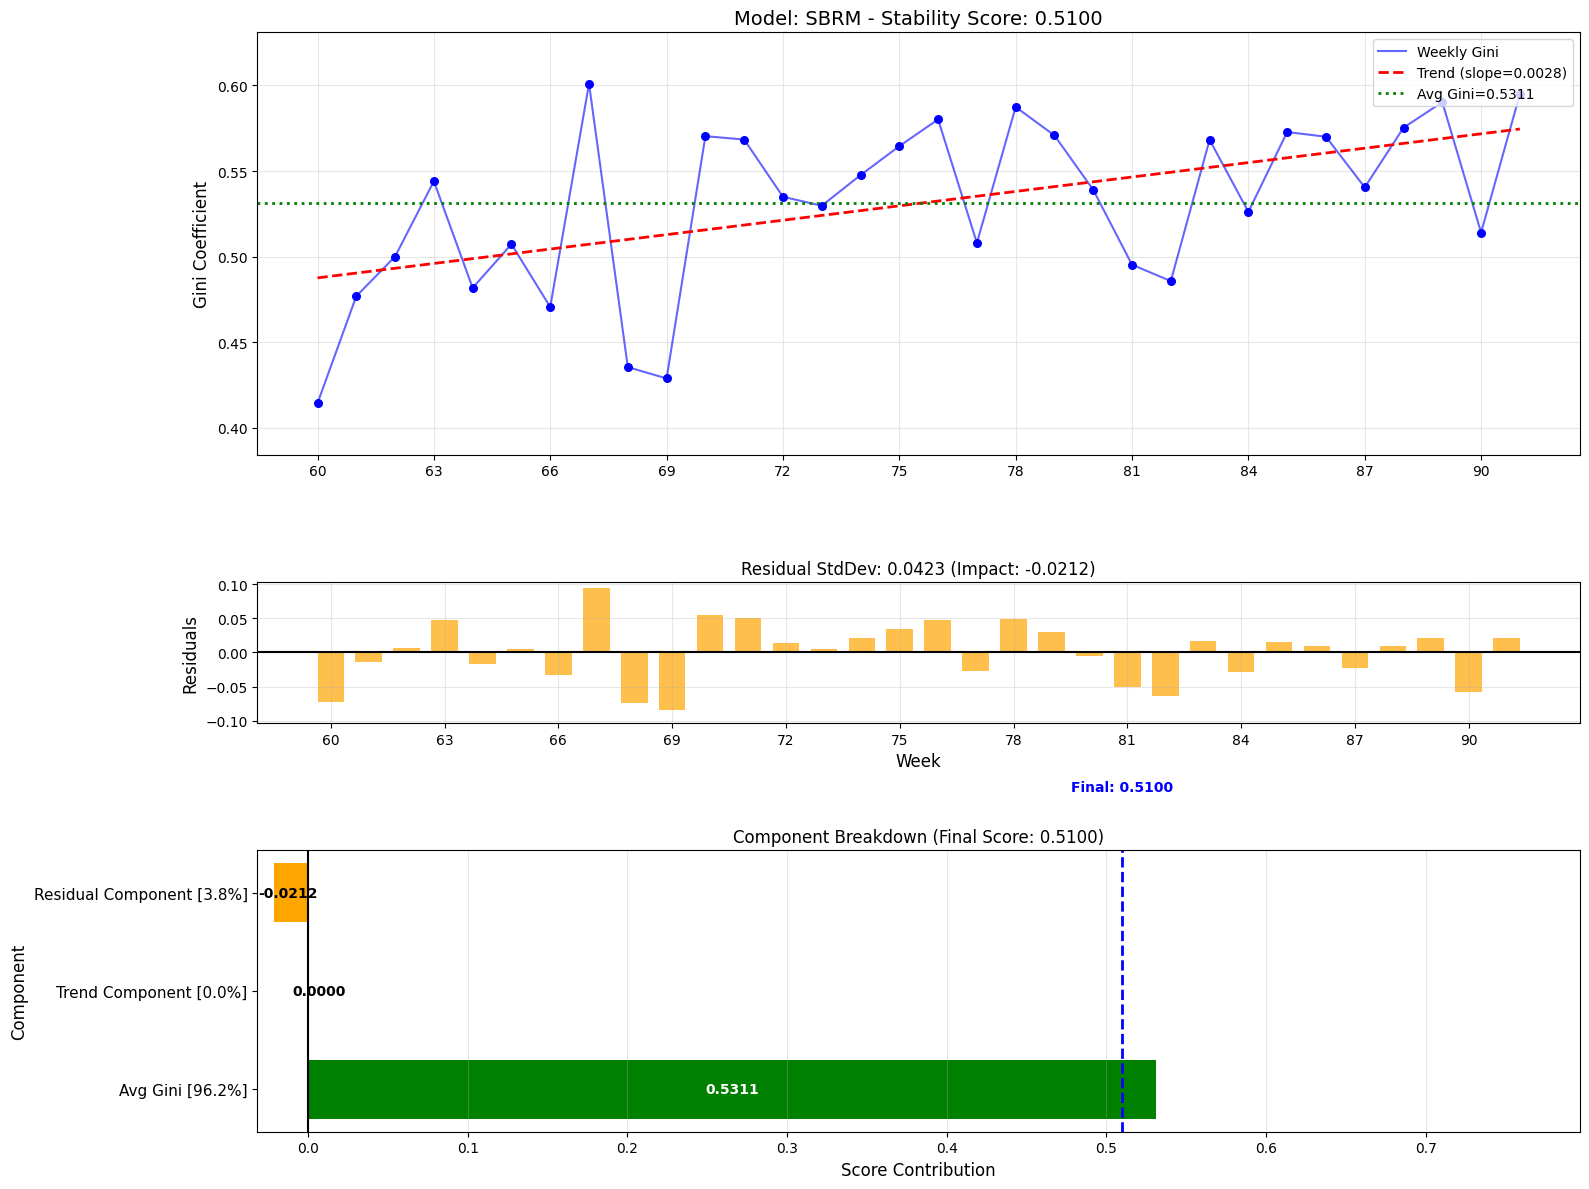

In [55]:
weeks = range(60,92)
fig = plot_stability_decomposition("SBRM", gini_in_time_test, weeks)
plt.savefig('SBRM_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()